In [1]:
include("../scripts/ideal_robot.jl")

In [2]:
using Distributions
using Random

In [3]:
mutable struct Camera <: AbstractCamera
    map
    lastdata
    distance_range
    direction_range
    distance_noise_rate
    direction_noise
end

In [4]:
function Camera(env_map, distance_range=(0.5,6.0), direction_range=(-pi/3, pi/3),
                distance_noise_rate=0.1, direction_noise=pi/90)
    self = Camera(ntuple(x->nothing, fieldcount(Camera))...)
    self.map = env_map
    self.lastdata = []
    self.distance_range = distance_range
    self.direction_range  = direction_range
    self.distance_noise_rate = distance_noise_rate
    self.direction_noise = direction_noise
    return self
end

Camera

In [13]:
function noise(self::Camera, relpos)
    ell = rand(Normal(relpos[1], abs(relpos[1])*self.distance_noise_rate))
    phi = rand(Normal(relpos[2],  self.direction_noise))
    return [ell, phi]
end

noise (generic function with 2 methods)

In [18]:
function data(self::Camera, cam_pose)
    observed = []
    for lm in self.map.landmarks
        z = observation_function(self, cam_pose, lm.pos)
        if visible(self, z)
            z = noise(self, z)
            push!(observed, (z, lm.id))
        end
    end
    self.lastdata = observed
    return observed
end

data (generic function with 2 methods)

In [19]:
mutable struct Robot <: AbstractRobot
    pose
    r
    color
    agent
    poses
    sensor
    noise_pdf
    distance_until_noise
    theta_noise
    bias_rate_nu
    bias_rate_omega
    stuck_pdf
    escape_pdf
    time_until_stuck
    time_until_escape
    is_stuck
    kidnap_pdf
    time_until_kidnap
    kidnap_dist
end

function Robot(pose, agent, sensor, color, noise_per_meter = 5, noise_std=pi/60,
    bias_rate_stds=(0.1,0.1), expected_stuck_time=1e100, expected_escape_time = 1e-100,
    expected_kidnap_time=1e100, kidnap_range_x=(-5.0, 5.0), kidnap_range_y=(-5.0, 5.0))
    rbt = Robot(ntuple(x->nothing, fieldcount(Robot))...)
    rbt.pose = pose
    rbt.r = 0.2
    rbt.agent = agent
    rbt.sensor = sensor
    rbt.poses = [pose]
    rbt.color = color
    rbt.noise_pdf = Exponential(1.0/(1e-100 + noise_per_meter))
    rbt.distance_until_noise = rand(rbt.noise_pdf)
    rbt.theta_noise = Normal(0, noise_std)
    rbt.bias_rate_nu = rand(Normal(1, bias_rate_stds[1]))
    rbt.bias_rate_omega = rand(Normal(1, bias_rate_stds[2]))
    rbt.stuck_pdf = Exponential(expected_stuck_time)
    rbt.escape_pdf = Exponential(expected_escape_time)
    rbt.time_until_stuck = rand(rbt.stuck_pdf)
    rbt.time_until_escape = rand(rbt.escape_pdf)
    rbt.is_stuck = false
    rbt.kidnap_pdf = Exponential(expected_kidnap_time)
    rbt.time_until_kidnap = rand(rbt.kidnap_pdf)
    rx = kidnap_range_x
    ry = kidnap_range_y
    rbt.kidnap_dist = (Uniform(rx[1], rx[2]), Uniform(ry[1], ry[2]), Uniform(0, 2*pi))
    return rbt
end

function noise(self::Robot, pose, nu, omega, time_interval)
    self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
    if self.distance_until_noise <= 0.0
        self.distance_until_noise += rand(self.noise_pdf)
        pose[3] += rand(self.theta_noise)
    end
    return pose
end

function bias(self::Robot, nu, omega)
    return nu*self.bias_rate_nu, omega*self.bias_rate_omega
end

function stuck(self::Robot, nu, omega, time_interval)
    if self.is_stuck
        self.time_until_escape -= time_interval
        if self.time_until_escape <= 0.0
            self.time_until_escape += rand(self.escape_pdf)
            self.is_stuck = false
        end
    else
        self.time_until_stuck -= time_interval
        if self.time_until_stuck <= 0.0
            self.time_until_stuck += rand(self.stuck_pdf)
            self.is_stuck = true
        end
    end
    return nu*(!self.is_stuck), omega*(!self.is_stuck)
end

function kidnap(self::Robot, pose, time_interval)
    self.time_until_kidnap -= time_interval
    if self.time_until_kidnap <= 0.0
        self.time_until_kidnap += rand(self.kidnap_pdf)
        return [rand(self.kidnap_dist[1]), rand(self.kidnap_dist[2]), rand(self.kidnap_dist[3])]
    else
        return pose
    end
end

function one_step(self::Robot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    nu, omega = bias(self, nu, omega)
    nu, omega = stuck(self, nu, omega, time_interval)
    self.pose = state_transition(self, nu, omega, time_interval)
    self.pose = noise(self, self.pose, nu, omega, time_interval)
    self.pose = kidnap(self, self.pose, time_interval)
end

one_step (generic function with 3 methods)

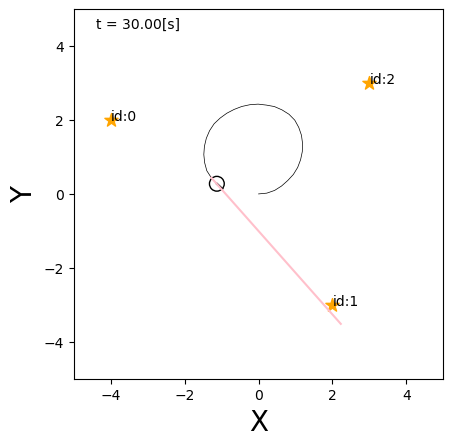

In [20]:
world = World(30, 1.0)
m = Map()
append_landmark(m, Landmark([-4.0,2.0]))
append_landmark(m, Landmark([2.0,-3.0]))
append_landmark(m, Landmark([3.0,3.0]))
append(world, m)

circling = Agent(0.2, 10.0/180*pi)
r = Robot([0.0, 0.0, 0.0], circling, Camera(m), "black")
append(world, r)
draw(world)

In [21]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAYA1tZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAF61liIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5FnEb6C9gPt3e826oHE1AgcXxvRCBxQI/BeMobygLn0j9VWXolTLRr1nefL0lQJDHRd0bMQ2bwJ+rzm8Mp/b24dtpJKsQryCKzCJcKad8rXWcKOAUajWn2P0NKgXGBFwI0M+idp/QrLQJJggEup5GqdX9LpivTz0Tg/GtPHRN/r0yThMt621zn7a4ylSl42LRaw5MezwM/+4GZwzEqm3AEN61OX4+ROEd9aArigTp3XWPCo1M3arBFgwglcnHb1e8ZbqIj4YaLbonxrArOWHmfSfBqXWPde/WRktmyHhQ5zaphFSjYU0Lns11vXjU1ONMVKVbNEfaKST3u+nzCLmQVjsoOK4fNxLvubsCygriI+/cKxxNVwhwMxig92FhVnxjeW0Qawhd7VT1zV28fRz3/DogADuAEMPhpq/RpKDv1qbZOKePOPffYRkCZ45FUWjVqZpelcn4ZADCZ5v4oynHm5NxE59pKbJ9JAsOPBdsd2kCu71nJq/EQYHSrbPdz4PH+mJYSEYOMqie4UU1DghGMCw8Li9jmSeOTLo4sh6JMZTDsgmMjiZqxotT4a/hxHfEupEYr4JwU4Vxzm/7S98Zg8N9S7JPyWDhPU3xZQklMgfm/wYdLHCTtRfKP7JEXZ/VKVtkKno7Kpra6QfW6uS5NohOTrHYi1QKJpwt4N6q1NFTZEINe5g3roZ3hBuhm45FVeZthTHPMarOUDfW4LgqacaabU+lIw6K0Kafl/pGLQ5S4xUfHpIxAxd3dvo+wd0w9UsWWLyGTQe6iptBTdFO3cd37VoNJIBSyrnVCZlOgQo+3mCLnlBHG8i5fwZp8RlVRWJQVv6BQarerxO8aBRS7QLzlkASjaG5nHHRRU4V+oHhagdcHTjZQthHRsjQmM4TRMsSP8CVDXj0XKLE/j7UDyDLvPxwbVwR1Wz5z47lb/agxwzzw+za+f6lKwJA8tAVv1lHJlUP9kaAv4FEs4p8wYKu++w/ti3ws9EbnwjCqGNIm1InjI/Lo6e4Jgq08+WcCA/njZoUWTvRTytSAU8nHRA1+i1zmFTB/HJ11H3rdGaRDEJI8QE8+GX1APtt7iQ5MHGPrwk8/rMrhfzUTAtzp5nZGHWYyDoUcz/48HFkECJfyo1kSkpcpbkeQrINSxQ04ofxiymSG3uH1nGUbM5qBhO+yfOXed5T3JCbvjlc4IfRh+gCbG7L15F5+lZgIihgvRo8szoZ7ixXbRU6idq/yBqwGS60zd65FbhISW1xftfN2OEEdRrL2vCQIqWlLXaOF3H1a9JmS4R6Rns/7d3PDMubsb7FE3Bfl3IrC2duJ4SX3hkPa1sjwEUnQ7YaH6Dz9PvTSfXPpctIKTXhH448111MrbHAhUEVKPhDZspJGWA2aSb5kM+dFJzKDP68PNCL09ufojasqMpbpmwGWGAFsWmUJ9zh/v/CzgCQDir7OW/QjDO9RQGmmumcxreJddtwz52i3l/91j0c8aqWo4WGHTA1imWf2gYoFiervxNmOTSokth56nDaigb3yf/TJbtGl4Dcij7iq+l/06dox5keBuHvDkAQeEsUZZriqq2gDKRvd1DNWgwej/sqH3AjoL+9Iuy1hr+ly3URJ7UWfJdB16jA5vk3XUS4RrsEcTTPwyvm5YqhtbO2R01enuoM3tSSBOHFGUArHHVQTGSKpfdtBrw9fZxOWOt+HZA54/b8HxmNwemUgZuUw4qp5EaQsUTjXeX4gVmV/J5HmgGA36MLcZWp7gTxuvEmI2K6sWqhnKFUYrsoVRD/6jXOOfQCqmtdRR14NXSOwLOnVCz8Xvcyf7eZWVN2TayhKvIjq+aUoGUEzKrEyMMQgk3lIN+92shWw0Kw2EDJd4VIAP9HlZlaPonRwSBYQfVVozGnwpwdXd0lEeIJTuQOu9UbZMAz2nPmsPD0lxsXpcolGhHyKfNviGkS1qxcF8r1SIeFakkYSN2V0Jvro4XVdp0AhKwdpSAzpm/pTi/fzRge3AKrWPKN0DTygRVH/yY2j2uaurQPKgNAX1eYlZJ1Z9yGVBeer6vmaZ4tdoKMfrF7/X0S9i/T5t5+luDu4hkJw95SCxYSahgP2t2xQ9QQNgmJ2oJbkG8V077oJyTjrQAA/x3hA8xdHxexk4rWBKEPnoYZy/cVLu/IFXhuL/J8uESsGcZ1JvB7z2Q0YHlhnVeUhakM275uYm11HGlZANJQ1m9aT2NnaXjNEbXR/IppAxoWr2sHywTaNx5sQS7JhmBFveqXn0Xmuk/IWKMQO1IcZ/b8d/KK/iCSLVwqiw+C+5p1wwJACk3SOUI4WPPx7p88PiJ760dadmfDdB/A8jK6/JLOXY8GSg2ooBZMWeqOJ3mS6jjHu8DK3DsmpdnPDxMXzT94m7yKaRGMp+q+NRES6iWUf6IIbCVUMOFWPM